# COMP4318/5318 Assignment 2: Image Classification

### Group number: A161  , SID1: 550077552 , SID2: 540561135

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [20]:
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [19]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train shape: (32000, 28, 28, 3)
y_train shape: (32000,)
Image shape: (28, 28, 3)
Pixel range: min = 0 , max = 255
First 5 labels: [7 3 4 2 6]


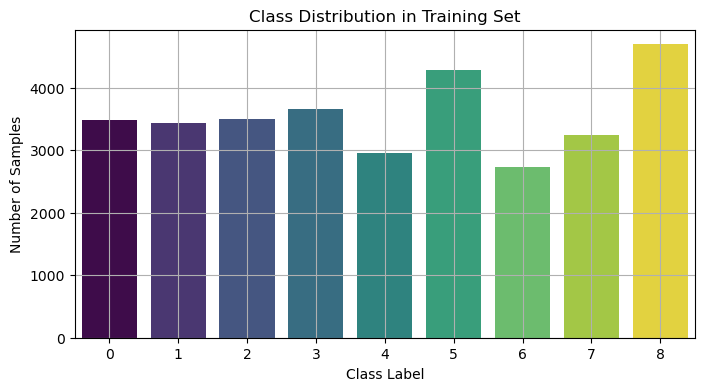

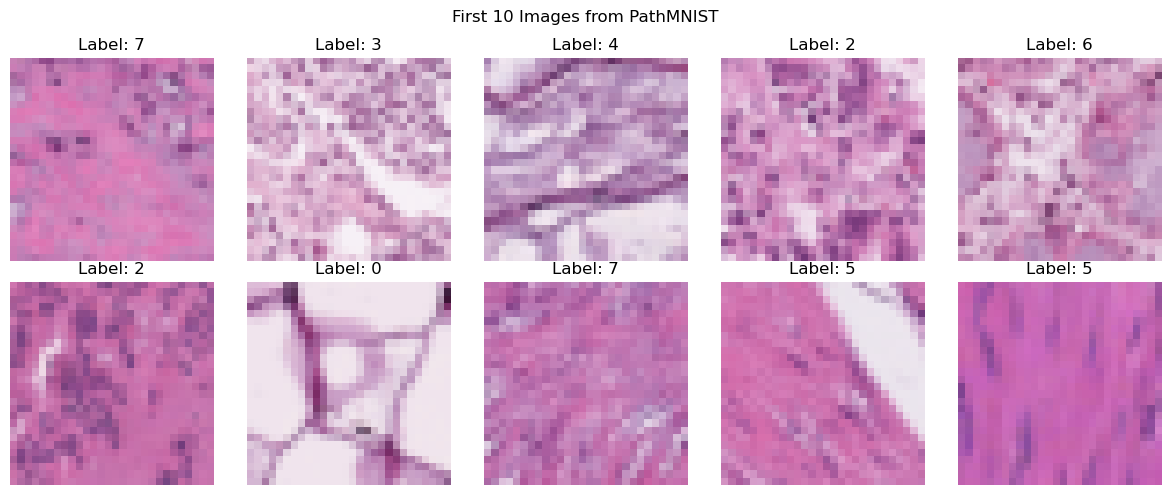

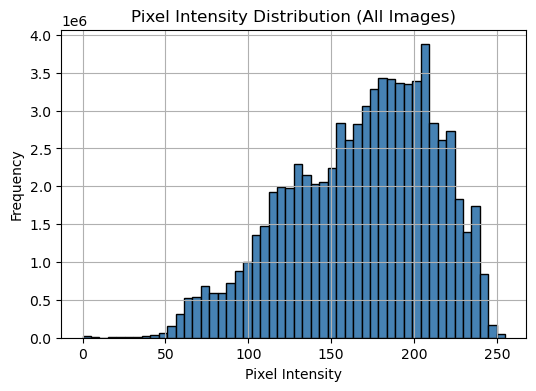

In [14]:
# Display dataset shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Check image shape and type
print("Image shape:", X_train[0].shape)
print("Pixel range: min =", X_train.min(), ", max =", X_train.max())

# Display first 5 labels
print("First 5 labels:", y_train[:5])

# Count the number of samples per class
class_counts = pd.Series(y_train).value_counts().sort_index()

# Convert to DataFrame for seaborn plotting
df_classes = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values
})

# Class distribution in the training set
plt.figure(figsize=(8, 4))
sns.barplot(data=df_classes, x='Class', y='Count', hue='Class', dodge=False, palette='viridis')
plt.legend([], [], frameon=False)  # hide the legend
plt.title("Class Distribution in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


# Plot first 10 sample images with labels
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("First 10 Images from PathMNIST")
plt.tight_layout()
plt.show()

# pixel intensity distribution
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=50, color='steelblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (All Images)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [16]:
# Preprocessing
X = np.load('Assignment2Data/X_train.npy').reshape(-1, 28*28*3) / 255.0
y = np.load('Assignment2Data/y_train.npy')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, random_state=42)

# Initial decision tree model (no tuning yet)
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)

# Validation accuracy
y_pred = dt_model.predict(X_valid)
print(f"Decision Tree Validation Accuracy: {accuracy_score(y_valid, y_pred):.4f}")


Decision Tree Validation Accuracy: 0.4691


### Fully connected neural network

In [8]:
from tensorflow import keras

# Reload image-shape data
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.9, random_state=42)

# MLP model without tuning
mlp_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(9, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model
history = mlp_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2436 - loss: 1.9784 - val_accuracy: 0.3887 - val_loss: 1.6324
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3847 - loss: 1.6372 - val_accuracy: 0.4569 - val_loss: 1.4925
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4262 - loss: 1.5212 - val_accuracy: 0.4997 - val_loss: 1.4241
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4607 - loss: 1.4496 - val_accuracy: 0.5047 - val_loss: 1.3618
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4855 - loss: 1.3839 - val_accuracy: 0.4762 - val_loss: 1.3942
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4987 - loss: 1.3524 - val_accuracy: 0.4953 - val_loss: 1.3583
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5112 - loss: 1.3163 - val_accuracy: 0.5272 - val_loss: 1.2714
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5028 - loss: 1.3184 - val_accuracy: 0.

### Convolutional neural network

In [9]:
# CNN model without tuning
cnn_model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(9, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit model
history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])

print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3667 - loss: 1.6774 - val_accuracy: 0.5719 - val_loss: 1.0671
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6009 - loss: 1.0667 - val_accuracy: 0.6737 - val_loss: 0.8830
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6548 - loss: 0.9337 - val_accuracy: 0.6566 - val_loss: 0.9269
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6809 - loss: 0.8724 - val_accuracy: 0.7337 - val_loss: 0.7615
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7021 - loss: 0.8198 - val_accuracy: 0.7575 - val_loss: 0.6999
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7195 - loss: 0.7858 - val_accuracy: 0.7487 - val_loss: 0.7051
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7315 - loss: 0.7398 - val_accuracy: 0.7672 - val_loss: 0.6460
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7337 - loss: 0.7283 - val_accuracy: 0.

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
# Stratified 5-fold cross-validation
cvFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=cvFold)

# Fit grid search on full dataset
print("Start grid searching...")
grid_search.fit(X, y)

# Report best parameters and score
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best criterion:", grid_search.best_params_['criterion'])
print("Best CV Score:", grid_search.best_score_)


Start grid searching...


### Fully connected neural network

In [19]:
def build_model(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),
        keras.layers.Flatten()
    ])

    for i in range(1, 3):
        model.add(keras.layers.Dense(
            units=hp.Choice(f"units_{i}", [100, 200]),
            activation=hp.Choice("activation", ["relu", "sigmoid", "tanh"])
        ))

    model.add(keras.layers.Dense(9, activation="softmax"))
    model.compile(optimizer=keras.optimizers.SGD(
        learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    directory="keras_tuning_results",
    project_name="assignment2_mlp"
)
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))


Reloading Tuner from keras_tuning_results\assignment2_mlp\tuner0.json


### Convolutional neural network

In [17]:
# Re-load fresh, unflattened image data for CNN tuning
X = np.load('Assignment2Data/X_train.npy') / 255.0
y = np.load('Assignment2Data/y_train.npy')

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Confirm shape (should be 4D)
print("X_train shape:", X_train.shape)  # should be (num_samples, 28, 28, 3)
#  Now your tuning code is safe to run
def build_model_cnn(hp):
    model = keras.models.Sequential([
        keras.layers.Input(shape=[28, 28, 3]),
        keras.layers.Conv2D(
            filters=hp.Choice("filters_1", [32, 64, 128]),
            kernel_size=hp.Choice("kernel_size_1", [3, 5]),
            activation=hp.Choice("activation_1", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(
            filters=hp.Choice("filters_2", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation=hp.Choice("activation_2", ["relu", "tanh"])
        ),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(hp.Float("dropout_rate", 0.3, 0.5, step=0.1)),
        keras.layers.Dense(9, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Choice("learning_rate", [0.1, 0.01, 0.001])
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Run tuning
tuner = keras_tuner.RandomSearch(
    build_model_cnn,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    directory="keras_tuning_results",
    project_name="assignment2_cnn"
)

tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))

X_train shape: (28800, 28, 28, 3)
Reloading Tuner from keras_tuning_results\assignment2_cnn\tuner0.json


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

In [53]:
# Use the best hyperparameters from grid search
best_depth = grid_search.best_params_['max_depth']
best_criterion = grid_search.best_params_['criterion']

# Train-test split (flattened data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Train the final Decision Tree model
final_dt = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion, random_state=42)
final_dt.fit(X_train, y_train)

# Evaluate on the test set
accuracy = final_dt.score(X_test, y_test)
print(f"Decision Tree Final Model Test Accuracy: {accuracy:.4f}")


KNN Final Model Test Accuracy: 0.2896


### Fully connected neural network

In [ ]:
# X_train and X_valid were already normalized earlier
X_test = np.load('Assignment2Data/X_test.npy') / 255.0
# Make sure input is flattened for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
# Final model trained on selected hyperparameters from keras-tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(2352,)))  # 使用扁平化输入
    model.add(keras.layers.Dense(hp.Int('units1', 64, 256, step=64), activation='relu'))
    model.add(keras.layers.Dense(hp.Int('units2', 32, 128, step=32), activation='relu'))
    model.add(keras.layers.Dense(9, activation='softmax'))  # 输出 9 类

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 获取最佳超参数并构建模型
best_hps = tuner.get_best_hyperparameters(1)[0]
model_nn = build_model(best_hps)

# Retrain on full training set (flattened)
history = model_nn.fit(X_train_flat, y_train, epochs=128, validation_data=(X_valid_flat, y_valid))

#plot the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for MLP')  # ← Add your title here
plt.show()


loss, accuracy = model_nn.evaluate(X_test_flat, y_test)
print(f"MLP Final Model Test Accuracy: {accuracy:.4f}")

# 输出最佳验证准确率和对应的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2245 - loss: 2.0196 - val_accuracy: 0.4059 - val_loss: 1.6282
Epoch 2/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3838 - loss: 1.6493 - val_accuracy: 0.4412 - val_loss: 1.5576
Epoch 3/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4186 - loss: 1.5626 - val_accuracy: 0.4809 - val_loss: 1.4610
Epoch 4/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4609 - loss: 1.4720 - val_accuracy: 0.4953 - val_loss: 1.4032
Epoch 5/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4746 - loss: 1.4300 - val_accuracy: 0.4712 - val_loss: 1.4348
Epoch 6/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4846 - loss: 1.4062 - val_accuracy: 0.5106 - val_loss: 1.3497
Epoch 7/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4950 - loss: 1.3749 - val_accuracy: 0.4953 - val_loss: 1.3547
Epoch 8/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4981 - loss: 1.3617 - val_accu

### Convolutional neural network

Epoch 1/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1874 - loss: 2.1172 - val_accuracy: 0.2828 - val_loss: 1.8424
Epoch 2/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3431 - loss: 1.7731 - val_accuracy: 0.3219 - val_loss: 1.7114
Epoch 3/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4448 - loss: 1.4969 - val_accuracy: 0.5559 - val_loss: 1.2702
Epoch 4/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5053 - loss: 1.3389 - val_accuracy: 0.5797 - val_loss: 1.1509
Epoch 5/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5367 - loss: 1.2484 - val_accuracy: 0.6219 - val_loss: 1.0647
Epoch 6/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5703 - loss: 1.1663 - val_accuracy: 0.4916 - val_loss: 1.3884
Epoch 7/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5864 - loss: 1.1244 - val_accuracy: 0.6216 - val_loss: 1.0654
Epoch 8/128
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6046 - loss: 1.0721 - val_accu

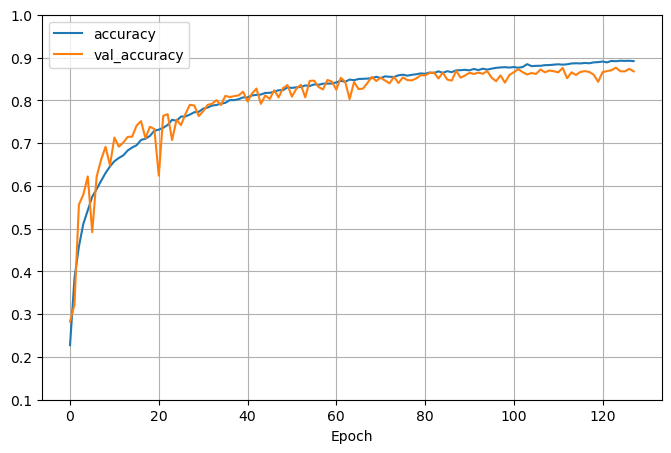

Best Epoch: 124
Best Validation Accuracy: 0.8763
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8776 - loss: 0.3556
CNN Model Test Accuracy: 0.8675


In [22]:
# 加载数据并分割（注意，CNN 使用原始图像数据，不进行 reshape）
X_full = np.load('Assignment2Data/X_train.npy') / 255.0
y_full = np.load('Assignment2Data/y_train.npy')

# 不进行 flatten，保持原图像 shape: (N, 28, 28, 3)
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.9, random_state=42)

# 获取最佳超参数
best_hps = tuner.get_best_hyperparameters(1)[0]

# 构建 CNN 模型
model_cnn = build_model_cnn(best_hps)

# 训练模型
history = model_cnn.fit(X_train, y_train, epochs=128, validation_data=(X_valid, y_valid))

#plot the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.1, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs for CNN')  # ← Add your title here
plt.show()


# 输出最佳验证准确率和对应的 epoch
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 在测试集上评估
loss, accuracy = model_cnn.evaluate(X_valid, y_valid)
print(f"CNN Model Test Accuracy: {accuracy:.4f}")